In [1]:
import math
import os
import time
from glob import glob
import numpy as np
import mxnet as mx
from mxnet import gluon, autograd
from mxnet.gluon import nn, rnn
import spacy

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
from collections import defaultdict

In [3]:
import xml.etree.ElementTree as ET

In [4]:
from functools import reduce
class ArgumentTree(object):
    def __init__(self, value, text=None):
        self.children = []
        self.parent = None
        self.value = value
        self.text = text
    
    def __repr__(self):
        if self.children:
            return '[{}: {}]'.format(self.value, ', '.join([str(c) for c in self.children]))
        else:
            return '{}({})'.format(self.value, self.text)
        
    @property
    def p_value(self):
        if self.parent:
            return self.parent.value
        else:
            return self.value
    
    def __len__(self):
        if self.children:
            return 1 + sum([len(l) for l in self.children])
        else:
            return 0
    
    @property
    def root(self):
        if self.isroot:
            return self
        else:
            return self.parent.root
        
    @property
    def isroot(self):
        return self.parent is None
    
    def search(self, value):
        if self.value == value:
            return self
        else:
            return next((c for c in (child.search(value) for child in self.children) if c is not None), None)
    
    def add(self, child):
        self.children.append(child)
        child.parent = self

In [5]:
def read_ac(xml):
    arguments = {x.get('id'):x.text for x in xml.findall('edu')}
    edges = [x for x in xml.findall('edge')]

    trees = []
    # parent (major claim) -> child (claims)
    for edge in edges:
        fr = edge.get('src')
        text = arguments.get(fr)
        to = edge.get('trg')
        while to.startswith('c'):
            to = next(edge for edge in edges if edge.get('id') == to).get('trg')

        child = next((node for node in (tree.search(fr) for tree in trees) if node is not None), ArgumentTree(fr, text))
        parent = next((node for node in (tree.search(to) for tree in trees) if node is not None), ArgumentTree(to))

        parent.add(child)
        trees.append(parent)
    return trees[0].root

In [6]:
nlp = spacy.load('en_core_web_lg')

/usr/local/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/usr/local/lib/python3.6/site-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]


In [50]:
STOPWORDS = ['I','...']

from sklearn.model_selection import ShuffleSplit
from collections import Counter
class MTCorpus(object):
    def __init__(self):
        files = sorted(glob('./arg-microtexts/corpus/en_extended/*.xml'))
        self.trees = []
        self.links = []
        self.types = []
        self.documents = []
        self.tokens = []
        self.lemmas = defaultdict(int)
        for file in files:
            with open(file,'r',encoding='UTF-8') as file:
                try:
                    xml = ET.parse(file)
                    ac_tree = read_ac(xml)
                    self.trees.append(ac_tree)
                    y = [int(ac_tree.search('a{}'.format(i)).p_value[1:])-1 for i in range(1, len(ac_tree)+1)]
                    types = [int(ac_tree.search('a{}'.format(i)).isroot) for i in range(1, len(ac_tree)+1)]
                    acs = [ac_tree.search('e{}'.format(i)).text for i in range(1, len(ac_tree)+1)]
                    '''Tokenizes a string.'''
                    document = [self.represent(ac) for ac in acs]
                except Exception as e:
                    try:
                        file.seek(0)
                        xml = ET.parse(file)
                        ac_tree = read_ac(xml)
                        self.trees.append(ac_tree)
                        y = [int(ac_tree.search('a{}'.format(i)).p_value[1:]) for i in range(0, len(ac_tree))]
                        types = [int(ac_tree.search('a{}'.format(i)).isroot) for i in range(0, len(ac_tree))]
                        '''Tokenizes a string.'''
                        acs = [ac_tree.search('e{}'.format(i)).text for i in range(0, len(ac_tree))]
                        document = [self.represent(ac) for ac in acs]
                    except Exception as e:
                        file.seek(0)
                        print(e)
                        print(file.read())
            self.links.append(y)
            self.types.append(types)
            self.documents.append(document)

        np.save('Ylinks_ext', self.links)
        np.save('Ytypes_ext', self.types)
        self.lemma_indices = dict(zip(self.lemmas.keys(),range(len(self.lemmas))))
        self.X_large = self._x_large()
        self.X_small = self._x_small()
                
    def represent(self, sent):
        # Tokenize sentence
        tokens = nlp(sent)
        final_tokens = []
        # Build lemma vocabulary           
        for token in tokens:
            if token.lemma_ in STOPWORDS or token.tag_ in {}:
                continue
            self.lemmas[token.lemma_] += 1
            final_tokens.append(token)
            
        # Return tokens
        return tokens
    
    def _x_small(self):
        representations = []
        
        for document in self.documents:
            representations.append([])
            for i, ac in enumerate(document):
                vectors = []
                for token in ac:
                    vectors.append(token.vector)
                vectors = np.array(vectors)
                
                # min and max across token embeddings
                mean = np.mean(vectors, axis=0)
                pos = [int(i==0)]
                r = np.concatenate([pos, mean], axis=0)
                representations[-1].append(r)
                
        representations = np.array(representations)
        np.save(file='X_small_ext',arr=representations)
        return representations
    
    def _x_large(self):
        representations = []
        
        for document in self.documents:
            representations.append([])
            for i, ac in enumerate(document):
                vectors = []
                bow = np.zeros(len(self.lemmas))
                for token in ac:
                    bow[self.lemma_indices[token.lemma_]] += 1
                    vectors.append(token.vector)
                vectors = np.array(vectors)
                
                # min and max across token embeddings
                maximum = np.max(vectors, axis=0)
                minimum = np.min(vectors, axis=0)                
                mean = np.mean(vectors, axis=0)
                pos = [int(i==0)]
                r = np.concatenate([pos, mean, maximum, minimum, bow], axis=0)
                representations[-1].append(r)
                
        representations = np.array(representations)
        np.save(file='X_large_ext',arr=representations)
        return representations

In [51]:
corpus = MTCorpus()

'NoneType' object has no attribute 'text'
<?xml version='1.0' encoding='UTF-8'?>
<arggraph id="micro_c054_maria">
  <edu id="e0"><![CDATA[I live in Michigan, where we have a deposit.]]></edu>
  <edu id="e1"><![CDATA[I regularly see people bringing huge amounts of bottles and cans to grocery stores to recycle them.]]></edu>
  <edu id="e2"><![CDATA[While I do not have exact statistics on the topic,]]></edu>
  <edu id="e3"><![CDATA[this indicates to me that deposits promote recycling and should therefore be adopted.]]></edu>
  <edu id="e4"><![CDATA[This has also become a source of income for homeless people.]]></edu>
  <edu id="e5"><![CDATA[I see homeless people picking up littered cans so they can later recycle them for the deposit,]]></edu>
  <edu id="e6"><![CDATA[which seems good to me.]]></edu>
  <adu id="a0" type="pro"/>
  <adu id="a1" type="opp"/>
  <adu id="a2" type="pro"/>
  <adu id="a3" type="pro"/>
  <adu id="a4" type="pro"/>
  <adu id="a5" type="pro"/>
  <edge id="c5" src="e1" 

In [9]:
corpus.trees[1]

[a3: e3(Higher fines are therefore the right measure against negligent, lazy or simply thoughtless dog owners.), [a1: e1(One can hardly move in Friedrichshain or Neukölln these days without permanently scanning the ground for dog dirt.)], [a2: e2(And when bad luck does strike and you step into one of the many 'land mines' you have to painstakingly scrape the remains off your soles.)], [a4: e4(Of course, first they'd actually need to be caught in the act by public order officers,)], [a5: e5(but once they have to dig into their pockets, their laziness will sure vanish!)]]

In [10]:
[corpus.trees[2].search('a{}'.format(i)).isroot for i in range(1, len(corpus.trees[0])+1)]

[True, False, False, False, False]

In [11]:
corpus.types[2]

[1, 0, 0, 0, 0]

In [12]:
corpus.links[2]

[1, 1, 2, 1, 1]

In [13]:
re = corpus.X_small

In [14]:
re[0][0].shape

(301,)

In [15]:
# Bag Of Words 
# Convert a collection of raw documents to a matrix of TF-IDF features.
# from sklearn.feature_extraction.text import TfidfVectorizer

all_texts = sorted(glob('./arg-microtexts/corpus/en/*.txt'))

# tfidf = TfidfVectorizer(norm='l2',min_df=0, use_idf=False, smooth_idf=False, sublinear_tf=True, stop_words='english')
# bow_representation = tfidf.fit_transform(all_texts)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(all_texts)
#print( vectorizer.vocabulary_ )
#print(len(vectorizer.vocabulary_))

#vec = DictVectorizer()

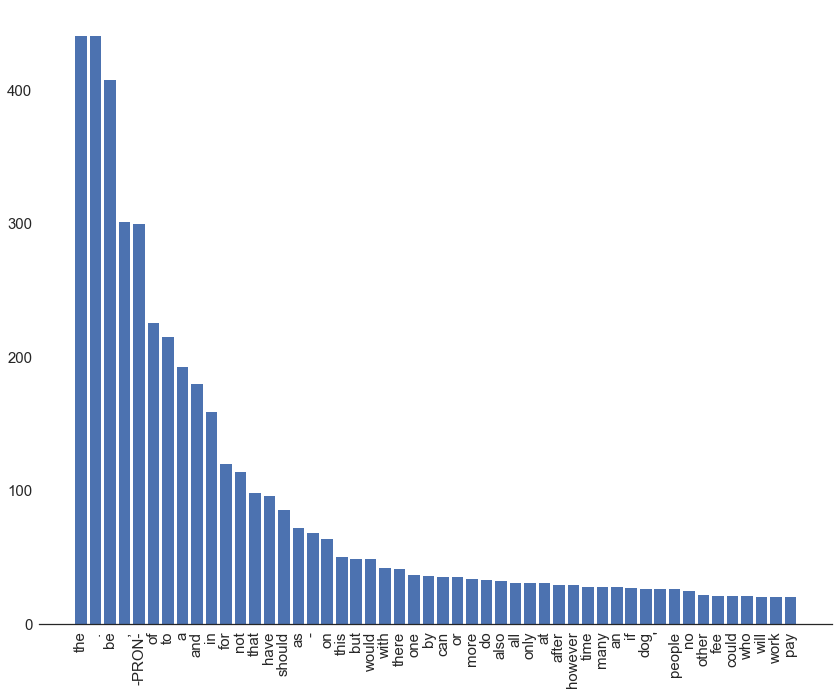

In [16]:
limit = 50
top_lemmas = dict(sorted(corpus.lemmas.items() ,key=lambda x: x[1], reverse=True)[:limit])
sns.set_style("white")
plt.figure(figsize=(12,10))
plt.bar(range(limit), list(top_lemmas.values())[:limit])
plt.xticks(range(limit), list(top_lemmas.keys())[:limit], rotation='vertical')
sns.despine(left=True)
plt.tight_layout();

In [17]:
doc = nlp('Hello goes')

In [18]:
doc[1].pos

99

In [19]:
top_tags = dict(sorted(corpus.tags.items() ,key=lambda x: x[1], reverse=True)[:100])
sns.set_style("white")
plt.figure(figsize=(16,10))
plt.bar(range(len(top_tags)), list(top_tags.values())[:100])
plt.xticks(range(len(top_tags)), list(top_tags.keys())[:100], rotation='vertical')
sns.despine(left=True)
plt.tight_layout();

AttributeError: 'MTCorpus' object has no attribute 'tags'